# Citation

Much of the code and examples are copied/modified from 

> Blueprints for Text Analytics Using Python by Jens Albrecht, Sidharth Ramachandran, and Christian Winkler (O'Reilly, 2021), 978-1-492-07408-3.
>

- https://github.com/blueprints-for-text-analytics-python/blueprints-text
- https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb

---

# Setup

In [46]:
%matplotlib inline

import os
from pathlib import Path
import helpsk as hlp
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from helpers.utilities import Timer, get_logger
from helpers.text_processing import count_tokens

def get_project_directory():
    return os.getcwd().replace('/source/executables', '')

standard_fig_size = (hlp.plot.STANDARD_WIDTH, hlp.plot.STANDARD_HEIGHT)

print(get_project_directory())

/Users/shanekercheval/repos/nlp-template


---

# Exploratory Data Analysis

This section provides a basic exploration of the text and dataset.

In [2]:
with Timer("Loading Data"):
    path = os.path.join(get_project_directory(), 'artifacts/data/processed/un-general-debates-blueprint.pkl')
    df = pd.read_pickle(path)

Started: Loading Data
Finished (0.80 seconds)


---

In [4]:
hlp.pandas.numeric_summary(df)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
session,"7,507",0,0.0%,0,0.0%,49.6,12.9,0.3,-0.2,-1.1,25,31.0,39.0,51.0,61.0,67.0,70
year,"7,507",0,0.0%,0,0.0%,"1,994.6",12.9,0.0,-0.2,-1.1,"1,970","1,976.0","1,984.0","1,996.0","2,006.0","2,012.0","2,015"
num_tokens,"7,507",0,0.0%,0,0.0%,"1,480.3",635.2,0.4,1.1,1.7,187,793.6,"1,005.5","1,358.0","1,848.0","2,336.4","5,688"
text_length,"7,507",0,0.0%,0,0.0%,"17,967.3","7,860.0",0.4,1.1,1.8,"2,362","9,553.8","12,077.0","16,424.0","22,479.5","28,658.2","72,041"


In [5]:
hlp.pandas.non_numeric_summary(df)

,# of Non-Nulls,# of Nulls,% Nulls,Most Freq. Value,# of Unique,% Unique
country,"7,507",0,0.0%,ALB,199,2.7%
country_name,"7,507",0,0.0%,Albania,199,2.7%
speaker,"7,507",0,0.0%,<unknown>,"5,429",72.3%
position,"7,507",0,0.0%,<unknown>,114,1.5%
text,"7,507",0,0.0%,33: May I first convey to our [...],"7,507",100.0%
tokens,"7,507",0,0.0%,"['may', 'first', 'convey', 'pr[...]","7,507",100.0%


---

In [6]:
df[df['speaker'].str.contains('Bush')]['speaker'].value_counts()

George W. Bush        4
Mr. George W. Bush    2
Bush                  1
George Bush           1
Mr. George W Bush     1
Name: speaker, dtype: int64

---

In [7]:
count_tokens(df['tokens']).head(20)

,frequency
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734
peace,72625
development,62632
states,59713
people,59338


---

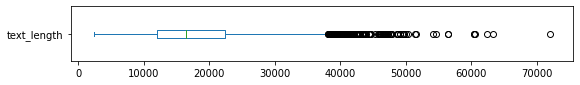

In [37]:
df['text_length'].plot(kind='box', vert=False, figsize=(9, 1));

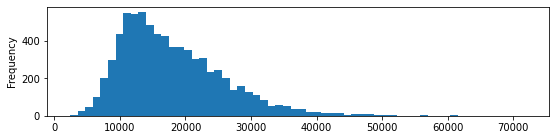

In [38]:
df['text_length'].plot(kind='hist', bins=60, figsize=(9, 2));

---

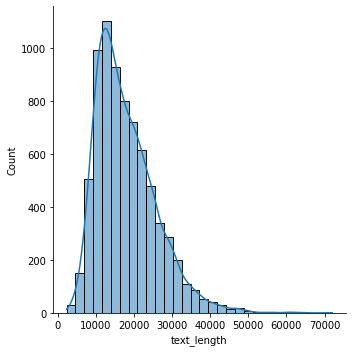

In [29]:
import seaborn as sns

#plt.figure(figsize=(9, 1))
sns.displot(df['text_length'], bins=30, kde=True);

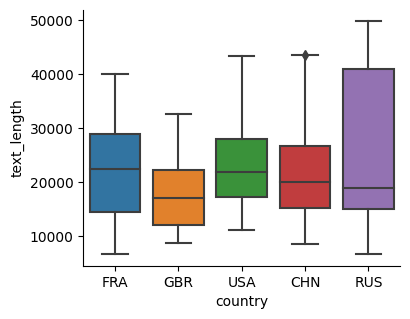

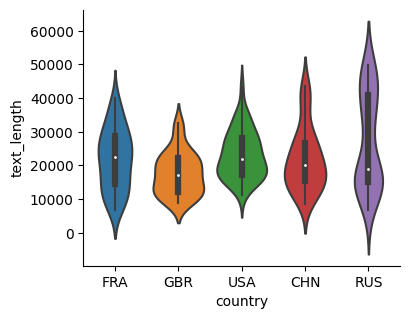

In [39]:
where = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS'])
g = sns.catplot(data=df[where], x="country", y="text_length", kind='box')
g.fig.set_size_inches(4, 3)
g.fig.set_dpi(100)
g = sns.catplot(data=df[where], x="country", y="text_length", kind='violin')
g.fig.set_size_inches(4, 3)
g.fig.set_dpi(100)

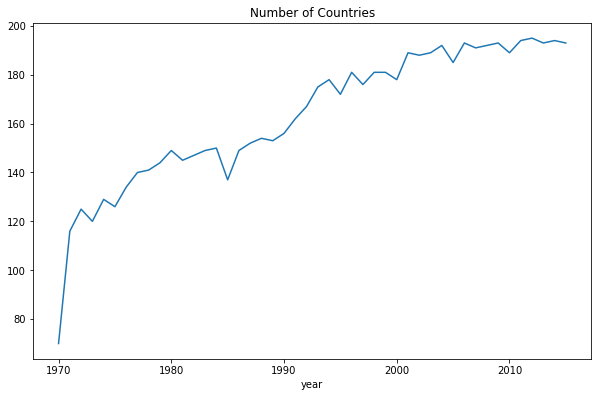

In [55]:
assert not df[['year', 'country']].duplicated().any()
df.groupby('year').size().plot(title="Number of Countries", figsize=hlp.plot.STANDARD_WIDTH_HEIGHT);

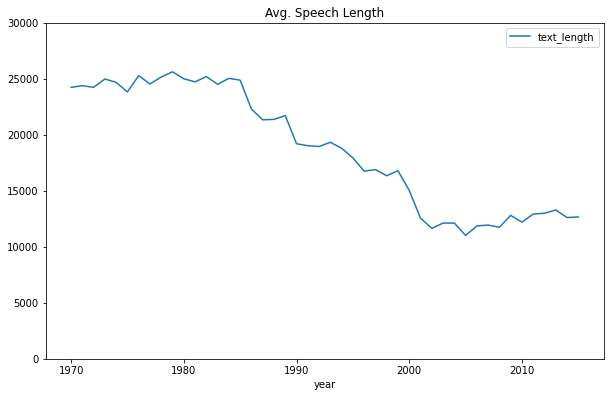

In [50]:
df.groupby('year').agg({'text_length': 'mean'}) \
  .plot(title="Avg. Speech Length", ylim=(0,30000), figsize=hlp.plot.STANDARD_WIDTH_HEIGHT);